<a href="https://colab.research.google.com/github/martindevoto/machine-learning-notebooks-personal/blob/main/CIFARPyTorchCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
transform = transforms.ToTensor()

In [ ]:
train_data = datasets.CIFAR10(root='../MyDrive',train=True,
                              download=True,transform=transform)

Files already downloaded and verified


In [ ]:
test_data = datasets.CIFAR10(root='../MyDrive',train=False,download=True,
                             transform=transform)

Files already downloaded and verified


In [ ]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../MyDrive
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../MyDrive
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
torch.manual_seed(101)

train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [ ]:
class_names = ['plane',' car',' bird', ' cat',' deer',' dog',' frog', 'horse',
               ' ship', ' truck']

In [ ]:
for images,labels in train_loader:
  break
  

In [ ]:
labels

tensor([3, 2, 0, 4, 9, 5, 1, 2, 4, 8])

Label: [3 2 0 4 9 5 1 2 4 8]
Class:  cat  bird plane  deer  truck  dog  car  bird  deer  ship


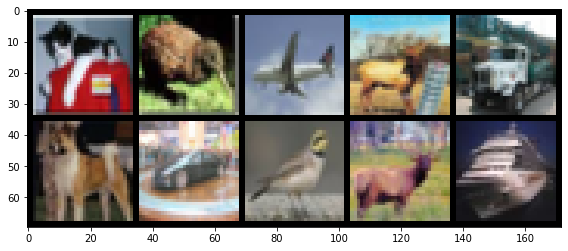

In [ ]:
# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images,nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
class ConvolutionalNetwork(nn.Module):

  def __init__(self):
    super().__init__()
    # Esto instancia la clase padre
    self.conv1 = nn.Conv2d(in_channels=3,
                           out_channels=6,kernel_size=5,
                           stride=1) # (1,6,5,1) Antes tenía un 1 input
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.fc1 = nn.Linear(6*6*16,120) # rounddown((32-2)/2-2)/2
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,X):

    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    X = X.view(-1,6*6*16)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X,dim=1)

In [ ]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
for param in model.parameters():
  print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [ ]:
sum([param.numel() for param in model.parameters()])

81590

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Run the training batches

  for b, (X_train,y_train) in enumerate(train_loader):
    b+=1
    y_pred = model(X_train)
    loss = criterion(y_pred,y_train)

    predicted = torch.max(y_pred.data,1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%1000 == 0:
      print(f'epoch: {i:2} batch {b:4} [{10*b:6}/50000] loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  with torch.no_grad():
    for b, (X_test,y_test) in enumerate(test_loader):

      y_val = model(X_test)
      predicted = torch.max(y_val.data,1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

print(f'\nDuration: {time.time()-start_time:.0f} seconds')

epoch:  0 batch 1000 [ 10000/50000] loss: 1.71153188 accuracy:  27.070%
epoch:  0 batch 2000 [ 20000/50000] loss: 1.33702445 accuracy:  33.090%
epoch:  0 batch 3000 [ 30000/50000] loss: 1.83077776 accuracy:  36.740%
epoch:  0 batch 4000 [ 40000/50000] loss: 1.69730473 accuracy:  39.042%
epoch:  0 batch 5000 [ 50000/50000] loss: 2.38257694 accuracy:  40.984%
epoch:  1 batch 1000 [ 10000/50000] loss: 1.18294084 accuracy:  50.210%
epoch:  1 batch 2000 [ 20000/50000] loss: 1.75360131 accuracy:  50.790%
epoch:  1 batch 3000 [ 30000/50000] loss: 0.82617319 accuracy:  50.997%
epoch:  1 batch 4000 [ 40000/50000] loss: 1.26634097 accuracy:  51.545%
epoch:  1 batch 5000 [ 50000/50000] loss: 1.46013427 accuracy:  52.048%
epoch:  2 batch 1000 [ 10000/50000] loss: 0.71482027 accuracy:  56.580%
epoch:  2 batch 2000 [ 20000/50000] loss: 1.39484668 accuracy:  56.275%
epoch:  2 batch 3000 [ 30000/50000] loss: 1.31580734 accuracy:  56.537%
epoch:  2 batch 4000 [ 40000/50000] loss: 1.23309207 accuracy:  

In [ ]:
torch.save(model.state_dict(),'myCIFARmodel.pt')

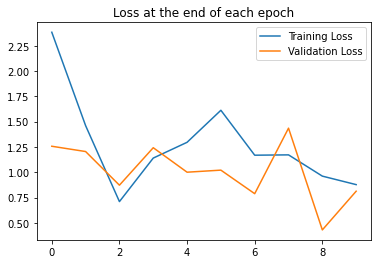

In [ ]:
plt.plot(train_losses,label='Training Loss')
plt.plot(test_losses,label='Validation Loss')
plt.title('Loss at the end of each epoch')
plt.legend();

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


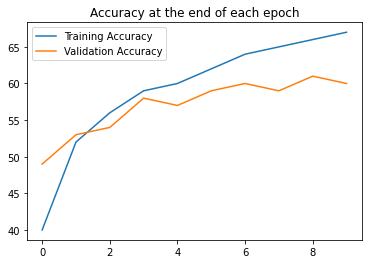

In [ ]:
plt.plot([t/500 for t in train_correct],label ='Training Accuracy')
plt.plot([t/100 for t in test_correct],label = 'Validation Accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [ ]:
print(test_correct)

[tensor(4980), tensor(5339), tensor(5494), tensor(5848), tensor(5770), tensor(5986), tensor(6042), tensor(5912), tensor(6104), tensor(6063)]


In [ ]:
num_c = test_correct[-1].item()

In [ ]:
num_c*100/10000

# Una garcha

60.63

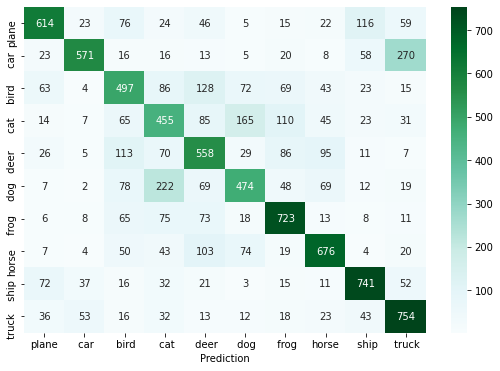

In [ ]:
test_load_all = DataLoader(test_data,batch_size=10000,shuffle=False)

with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_all:
    y_val = model(X_test)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted==y_test).sum()

arr = confusion_matrix(y_test.view(-1),predicted.view(-1))
df_cm = pd.DataFrame(arr,class_names,class_names)
plt.figure(figsize=(9,6))
sns.heatmap(df_cm,annot=True,fmt='d',cmap='BuGn')
plt.xlabel('Prediction')
plt.ylabel,('Label (ground truth)')
plt.show();